# Time Series Modeling with Amazon Forecast and DeepAR on SageMaker

# Introduction

Amazon offers customers a multitude of time series prediction services, including **DeepAR on SageMaker** and the fully managed service **Amazon Forecast**. **Amazon Forecast** offers a no code solution to perform time series prediction as well as offering multiple algorithms for prediction. **DeepAR on SageMaker** models run on **EC2** instances and thus run much quicker than **Amazon Forecast**. There are more nuances as well between the services that will be explored throughout this notebook, but important points will be outlined in the **Conclusion** section of the notebook. It may not often be clear when to use one service over the other, so this notebook aims to:
- Demonstrate how to use both services on the same dataset
- Educate users on features of both services
- Guide users on the best AWS service for specific use cases

For convenience, here is an overview of the structure of this notebook:
1. [Introduction](#Introduction)
2. [Loading and Exploring Data](#Loading-and-Exploring-Data)
 - [Obtaining Data From S3](#Obtaining-Data-From-S3)
 - [Data Manipulation](#Data-Manipulation)
 - [Visualizing Data](#Visualizing-Data)
3. [SageMaker DeepAR](#SageMaker-DeepAR)
 - [JSON Formatting](#JSON-Formatting)
 - [S3 Upload](#S3-Upload)
 - [Train Model](#Train-Model)
 - [Inference](#Inference)
 - [Interpreting Results](#Interpreting-Results)
 - [Visualizing Results](#Visualizing-Results)
4. [Amazon Forecast](#Amazon-Forecast)
 
We will consider a real use case using the [Beijing Multi-Site Air-Quality Data Data Set](https://archive.ics.uci.edu/ml/datasets/Beijing+Multi-Site+Air-Quality+Data) which features hourly air pollutants data from 12 air-quality monitoring sites from March 1st, 2013 to February 28th, 2017, and is featured in the [[1](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5627385/)] academic paper.

In [202]:
!pip3 install gluonts

In [207]:
import boto3
import os
import pandas as pd
import numpy as np
import json
import simplejson
import sagemaker
from IPython.display import display

import matplotlib.pyplot as plt
import seaborn as sns

# Loading and Exploring Data

Before we begin importing and exploring our data, let's define our **file paths/create directories** for convenience:

In [287]:
# define s3 bucket we're working in
bucket = "byj"
# ^ CHANGE BUCKET TO sagemaker.Session().default_bucket() IN PRODUCTION!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

# we'll define a version number to make this notebook reproducible 
version = 1
     
# create directories for use later
dirs = ["data", "deepar", "forecast", "deepar/to_export", "forecast/to_export"]

for dir_name in dirs:
    if not os.path.isdir(dir_name):
        os.makedirs(dir_name)
        
dataset_path = "data/dataset"
deepar_export_path = "deepar/to_export"
deepar_training_path = "{}/training.json".format(deepar_export_path)
deepar_test_path = "{}/test.json".format(deepar_export_path)
deepar_s3_training_path = "deepar/train.json"
deepar_s3_test_path = "deepar/test.json"
deepar_s3_output_path = "deepar/output"

## Obtaining Data From S3

This section will be demonstrating how to import data from an S3 bucket, but one can import their data whichever way is convenient. The data for this example will be imported from the `sagemaker-sample-files` **S3 Bucket**. 


To communicate with S3 outside of our console, we'll use the **Boto3** python3 library. We'll then initialize an **S3 client** and use that object as our interface. More functionality between **Boto3** and **S3** can be found here: [Boto3 Amazon S3 Examples](https://boto3.amazonaws.com/v1/documentation/api/latest/guide/s3-examples.html)

In [4]:
s3 = boto3.client("s3")

Now we can download our file (named `PRSA2017_Data_20130301-20170228` in the path `datasets/timeseries/beijing_air_quality`) and save it to our local `data` folder as `dataset.zip`.

#### Citations
- Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

In [5]:
example_filename = "PRSA2017_Data_20130301-20170228"

s3.download_file(
    "sagemaker-sample-files", 
    f"datasets/timeseries/beijing_air_quality/{example_filename}.zip", 
    f"data/dataset.zip"
)

Since our dataset is a zip, we can go ahead and unzip it. We'll use the Unix `unzip` command here, but any method of decompression is fine:

In [6]:
!unzip data/dataset.zip

Archive:  data/dataset.zip
   creating: PRSA_Data_20130301-20170228/
  inflating: PRSA_Data_20130301-20170228/PRSA_Data_Aotizhongxin_20130301-20170228.csv  
  inflating: PRSA_Data_20130301-20170228/PRSA_Data_Changping_20130301-20170228.csv  
  inflating: PRSA_Data_20130301-20170228/PRSA_Data_Dingling_20130301-20170228.csv  
  inflating: PRSA_Data_20130301-20170228/PRSA_Data_Dongsi_20130301-20170228.csv  
  inflating: PRSA_Data_20130301-20170228/PRSA_Data_Guanyuan_20130301-20170228.csv  
  inflating: PRSA_Data_20130301-20170228/PRSA_Data_Gucheng_20130301-20170228.csv  
  inflating: PRSA_Data_20130301-20170228/PRSA_Data_Huairou_20130301-20170228.csv  
  inflating: PRSA_Data_20130301-20170228/PRSA_Data_Nongzhanguan_20130301-20170228.csv  
  inflating: PRSA_Data_20130301-20170228/PRSA_Data_Shunyi_20130301-20170228.csv  
  inflating: PRSA_Data_20130301-20170228/PRSA_Data_Tiantan_20130301-20170228.csv  
  inflating: PRSA_Data_20130301-20170228/PRSA_Data_Wanliu_20130301-20170228.csv  
  infla

Let's rename our file to `dataset` and move it to the `./data` path for convenience:

In [7]:
!mv PRSA_Data_20130301-20170228 data/dataset

In [8]:
# Taking a quick look at our file structure
!ls data/dataset

PRSA_Data_Aotizhongxin_20130301-20170228.csv
PRSA_Data_Changping_20130301-20170228.csv
PRSA_Data_Dingling_20130301-20170228.csv
PRSA_Data_Dongsi_20130301-20170228.csv
PRSA_Data_Guanyuan_20130301-20170228.csv
PRSA_Data_Gucheng_20130301-20170228.csv
PRSA_Data_Huairou_20130301-20170228.csv
PRSA_Data_Nongzhanguan_20130301-20170228.csv
PRSA_Data_Shunyi_20130301-20170228.csv
PRSA_Data_Tiantan_20130301-20170228.csv
PRSA_Data_Wanliu_20130301-20170228.csv
PRSA_Data_Wanshouxigong_20130301-20170228.csv


## Data Manipulation

This specific dataset comes in 12 separate `CSV` files as our data comes from 12 different air-quality monitoring sites in Beijing. Let's load this data into a list of separate DataFrames:

In [29]:
dataset = [pd.read_csv("{}/{}".format(dataset_path, file_name)) for file_name in os.listdir(dataset_path)]

Both **SageMaker DeepAR** and **Amazon Forecast** use `datetime` objects for their time series cataloging, so we'll convert our `year`,`month`,`day`,`hour` columns into `datetime` column. Since we've represented these columns into our new `datetime` column, we can drop our `year`,`month`,`day`,`hour` columns from earlier. We can also drop the `No` column as our data is already in order.

In [30]:
for df in dataset:
    df.insert(0, "datetime", pd.to_datetime(df[['year', 'month', 'day', 'hour']]))
    df.drop(columns = ["No", "year", "month", "day", "hour"], inplace = True)
    
display(dataset[0])

## Visualizing Data
Let's take a look at the start and end times of our dataset:

In [32]:
print("Number of Time Series: {}".format(len(dataset)))
for df in dataset:
    print("Start Datetime: {}, End Datetime: {}".format(df["datetime"].min(), df["datetime"].max()))

Number of Time Series: 12
Start Datetime: 2013-03-01 00:00:00, End Datetime: 2017-02-28 23:00:00
Start Datetime: 2013-03-01 00:00:00, End Datetime: 2017-02-28 23:00:00
Start Datetime: 2013-03-01 00:00:00, End Datetime: 2017-02-28 23:00:00
Start Datetime: 2013-03-01 00:00:00, End Datetime: 2017-02-28 23:00:00
Start Datetime: 2013-03-01 00:00:00, End Datetime: 2017-02-28 23:00:00
Start Datetime: 2013-03-01 00:00:00, End Datetime: 2017-02-28 23:00:00
Start Datetime: 2013-03-01 00:00:00, End Datetime: 2017-02-28 23:00:00
Start Datetime: 2013-03-01 00:00:00, End Datetime: 2017-02-28 23:00:00
Start Datetime: 2013-03-01 00:00:00, End Datetime: 2017-02-28 23:00:00
Start Datetime: 2013-03-01 00:00:00, End Datetime: 2017-02-28 23:00:00
Start Datetime: 2013-03-01 00:00:00, End Datetime: 2017-02-28 23:00:00
Start Datetime: 2013-03-01 00:00:00, End Datetime: 2017-02-28 23:00:00


Before we visualize our data, we can see that we have 12 time series with the same start and end dates. However, DeepAR on SageMaker does not need every time series to have the same start and end dates. For this demonstration, we'll predict on the temperature column, or `TEMP`. *We can ignore all other columns for now.*

Let's visualize our first time series:

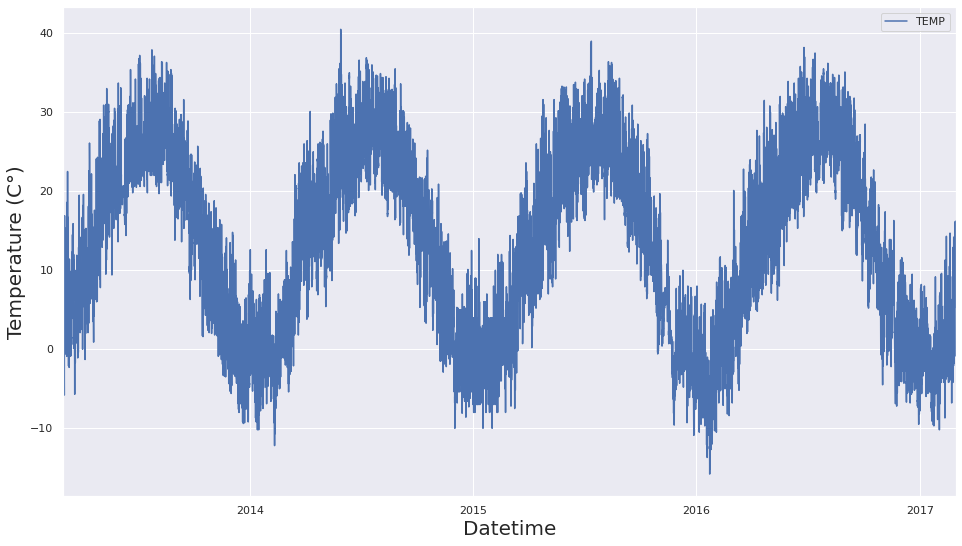

In [275]:
sns.set(rc={'figure.figsize': (16, 9)})
figure = dataset[0][["datetime", "TEMP"]].plot(x = "datetime", y = "TEMP")
figure.set_xlabel("Datetime", fontsize = 20)
figure.set_ylabel("Temperature (C°)", fontsize = 20)
plt.show()

![Intial Visual](./images/initial_temp_visual.png)

# SageMaker DeepAR

## JSON Formatting

Now we'll demonstrate how to use this dataset in **SageMaker DeepAR** and predict. 

SageMaker's DeepAR expects input in a JSON format with these specific fields for **each** time series:
- `start`
- `target`
- `cat` (optional)
- `dynamic_feat` (optional)

Further information about the DeepAR input formatting can be found here: [DeepAR Input/Output Interface](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html#deepar-inputoutput).

SageMaker DeepAR recommends a prediction length of `<=400` as large values decrease the algorithms accuracy and speed. Thus, let's set the length of our test time series and prediction length to the last two weeks of our data, or `14*24 = 336` observations. Useful information about best practices for DeepAR can be found here: [DeepAR Best Practices](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html#deepar_best_practices). Since we have missing values in our time series, we must account for these. Luckily, DeepAR accepts missing values as long as they're `"NaN"` strings or encoded as `null` literals, as we will be exporting our time series to `JSON` to train the DeepAR model. One could also choose to replace all missing values with the mean of each time series.

In [166]:
prediction_length = 14 * 24 # 14 days

deepar_training = [
    {
        "start": str(df["datetime"].min()),
        "target": df["TEMP"].fillna("NaN").tolist()[:-prediction_length]
    }
    for df in dataset
]

deepar_test = [
    {
        "start": str(df["datetime"].min()),
        "target": df["TEMP"].fillna("NaN").tolist()
    }
    for df in dataset
]

Next, we'll define a function to export our dictionaries into JSON files to make our data properly input into SageMaker DeepAR:

In [165]:
def write_dicts_to_json(path, data):
    with open(path, "wb") as file_path:
        for ts in data:
            file_path.write(json.dumps(ts).encode("utf-8"))
            file_path.write("\n".encode("utf-8"))

Now we can export our dictionaries in a JSON format into the paths we defined earlier:

In [37]:
write_dicts_to_json(deepar_training_path, deepar_training)
write_dicts_to_json(deepar_test_path, deepar_test)

## S3 Upload

SageMaker DeepAR gets its data for training from S3, so we'll use the previously defined **Boto3 S3 Client** to upload our JSON files to S3. However, uploading files through the AWS console is another option and does not require code.

In [38]:
s3.upload_file(deepar_training_path, bucket, deepar_s3_training_path)
s3.upload_file(deepar_test_path, bucket, deepar_s3_test_path)

## Train Model

Now that we've formatted our data properly, we can train our model. When initializing our estimator, we must specify an instance type. Available options as well as pricing can be viewed here: [Available SageMaker Studio Instance Types](https://aws.amazon.com/sagemaker/pricing/). We also need to pass an Image URI to specify which algorithm we want to use, as well as pass required parameters to our `Estimator`. Further documentation on retrieving Image URIs and the `sagemaker.estimator.Estimator` class can be found here:

- [Image URI API](https://sagemaker.readthedocs.io/en/stable/api/utility/image_uris.html)
- [SageMaker Estimator API](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html)

In [39]:
image_uri = sagemaker.image_uris.retrieve("forecasting-deepar", boto3.Session().region_name)
role = sagemaker.get_execution_role()
sagemaker_session = sagemaker.Session()

estimator = sagemaker.estimator.Estimator(
    sagemaker_session = sagemaker_session,
    image_uri = image_uri,
    role = role,
    instance_count = 1,
    instance_type = 'ml.c5.2xlarge',
    base_job_name = 'DEMO-deepar',
    output_path = "s3://{}/{}".format(bucket, deepar_s3_output_path)
)

Now we need to configure the DeepAR instance's hyperparameters to our specific needs. There are four required hyperparameters that we must define, but there are 16 total tunable hyperparameters. All tunable hyperparameters and detailed descriptions can be found here: [DeepAR Hyperparameters](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar_hyperparameters.html).



In [40]:
hyperparameters = {
    'epochs': '50',
    'time_freq': 'H',
    'prediction_length': prediction_length,
    'context_length': prediction_length,
}

estimator.set_hyperparameters(**hyperparameters)

After setting the hyperparameters, we can train our model. One run of the training job took `1543 seconds`, or approximately `25 minutes`.

In [41]:
estimator.fit(inputs = {
    'train': "s3://{}/{}".format(bucket, deepar_s3_training_path),
    'test': "s3://{}/{}".format(bucket, deepar_s3_test_path)
})

2022-07-27 23:46:11 Starting - Starting the training job...
2022-07-27 23:46:27 Starting - Preparing the instances for trainingProfilerReport-1658965571: InProgress
......
2022-07-27 23:47:35 Downloading - Downloading input data...
2022-07-27 23:48:08 Training - Downloading the training image..Arguments: train
/opt/amazon/lib/python3.7/site-packages/jsonref.py:8: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, MutableMapping, Sequence
[07/27/2022 23:48:26 INFO 139974144526144] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'_kvstore': 'auto', '_num_gpus': 'auto', '_num_kv_servers': 'auto', '_tuning_objective_metric': '', 'cardinality': 'auto', 'dropout_rate': '0.10', 'early_stopping_patience': '', 'embedding_dimension': '10', 'learning_rate': '0.001', 'likelihood': 'stu

## Inference

After training our model, we must initialize an endpoint to call our model. This particular endpoint uses an `ml.c5.2xlarge` instance and took `2 minutes 31 seconds` to initialize.

In [281]:
%%time
job_name = estimator.latest_training_job.name

endpoint_name = sagemaker_session.endpoint_from_job(
    job_name = job_name,
    initial_instance_count = 1,
    instance_type = "ml.c5.2xlarge",
    image_uri = image_uri,
    role = role,
)

-----!CPU times: user 114 ms, sys: 8.26 ms, total: 122 ms
Wall time: 2min 31s


Then, we can initialize a predictor from our endpoint to recieve time series predictions:

In [282]:
from sagemaker.serializers import JSONSerializer

predictor = sagemaker.predictor.Predictor(endpoint_name = endpoint_name, sagemaker_session = sagemaker_session, serializer = JSONSerializer())

**DeepAR** requires our request be in a `JSON` request format as input to recieve predictions. The following example is from the [DeepAR JSON Request Formats](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar-in-formats.html) documentation page where request definition is outlined:

    {
        "instances": [
            {
                "start": "2009-11-01 00:00:00",
                "target": [4.0, 10.0, "NaN", 100.0, 113.0],
                "cat": [0, 1],
                "dynamic_feat": [[1.0, 1.1, 2.1, 0.5, 3.1, 4.1, 1.2, 5.0, ...]]
            },
            {
                "start": "2012-01-30",
                "target": [1.0],
                "cat": [2, 1],
                "dynamic_feat": [[2.0, 3.1, 4.5, 1.5, 1.8, 3.2, 0.1, 3.0, ...]]
            },
            {
                "start": "1999-01-30",
                "target": [2.0, 1.0],
                "cat": [1, 3],
                "dynamic_feat": [[1.0, 0.1, -2.5, 0.3, 2.0, -1.2, -0.1, -3.0, ...]]
            }
        ],
        "configuration": {
             "num_samples": 50,
             "output_types": ["mean", "quantiles", "samples"],
             "quantiles": ["0.5", "0.9"]
        }
    }
    
Only types specified in the request will be present in the predictor's response. Valid values for the `output_types` field are: `"mean"`,`"quantiles"`, and `"samples"`. Furthermore, the `"cat"` and/or `"dynamic_feat"` fields of each instance should be omitted if these fields were not used to train the model. Let's define our request, where we'll request predictions for the `0.1`, `0.5`, and `0.9` quantiles.

In [203]:
predictor_input = {
    "instances": deepar_training,
    "configuration": {
         "output_types": ["quantiles"],
         "quantiles": ["0.1", "0.5", "0.9"]
    }
}

Finally, we can obtain a prediction from our model for the `prediction_length` number of instances following our requested time series, and conforming to the `time_freq` (time frequency) specified in our hyperparameters. This prediction took approximately `8 seconds` to receive a response.

In [283]:
%%time
prediction = predictor.predict(predictor_input)

CPU times: user 150 ms, sys: 24.1 ms, total: 174 ms
Wall time: 8.13 s


## Interpreting Results
The resulting prediction will come in a `JSON` format. The reponse is within a dictionary formatted like so: [DeepAR JSON Reponse Formats](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar-in-formats.html#deepar-json-response). The following example is from the previously mentioned page:

    {
        "predictions": [
            {
                "quantiles": {
                    "0.9": [...],
                    "0.5": [...]
                },
                "samples": [...],
                "mean": [...]
            },
            {
                "quantiles": {
                    "0.9": [...],
                    "0.5": [...]
                },
                "samples": [...],
                "mean": [...]
            },
            {
                "quantiles": {
                    "0.9": [...],
                    "0.5": [...]
                },
                "samples": [...],
                "mean": [...]
            }
        ]
    }

Let's define a method to help us decode the predictor's `JSON` response and load it onto a DataFrame:

In [205]:
def prediction_to_df(response):
    
    data = json.loads(response)
    dataframes = []
    
    for ts in data["predictions"]:
        if "quantiles" in ts:
            # Since the quantiles response comes in a list within the dictionary, we will append the quantiles
            # dictionary of each time series to the mean and samples(if requested) of those respective time series
            ts.update(ts["quantiles"])
            ts.pop("quantiles")
        dataframes.append(pd.DataFrame(data = ts))
            
    
    return dataframes

Now that we've obtained our predictions(that came in a `JSON` format) and defined a method to decode these predictions, we can see our results in a pandas `DataFrame` format:

In [262]:
deepar_results = prediction_to_df(prediction)

display(deepar_results[0])

,0.1,0.5,0.9
0,-2.940695,-1.628008,-0.549410
1,-3.369462,-1.993387,-0.375379
2,-3.627221,-2.347654,-0.036202
3,-4.591366,-2.798056,-0.978721
4,-5.124326,-3.444217,-1.783205
...,...,...,...
331,-2.012897,3.077488,6.359476
332,-3.056863,2.192014,5.796380
333,-4.235722,1.892555,5.436224
334,-4.692932,2.148739,5.106102


## Visualizing Results
Let's visualize our predictions after acquisition. First, let's append our `target` values to our results for convenient comparison. Then, we'll plot all requested quantiles onto the same plot with the `target` values to see how DeepAR did.

In [263]:
for i in range(len(deepar_results)):
    deepar_results[i] = pd.concat([dataset[i]["TEMP"].tail(prediction_length).reset_index(drop=True), deepar_results[i]], axis=1)
    deepar_results[i] = deepar_results[i].rename(columns = {"TEMP": "target"})

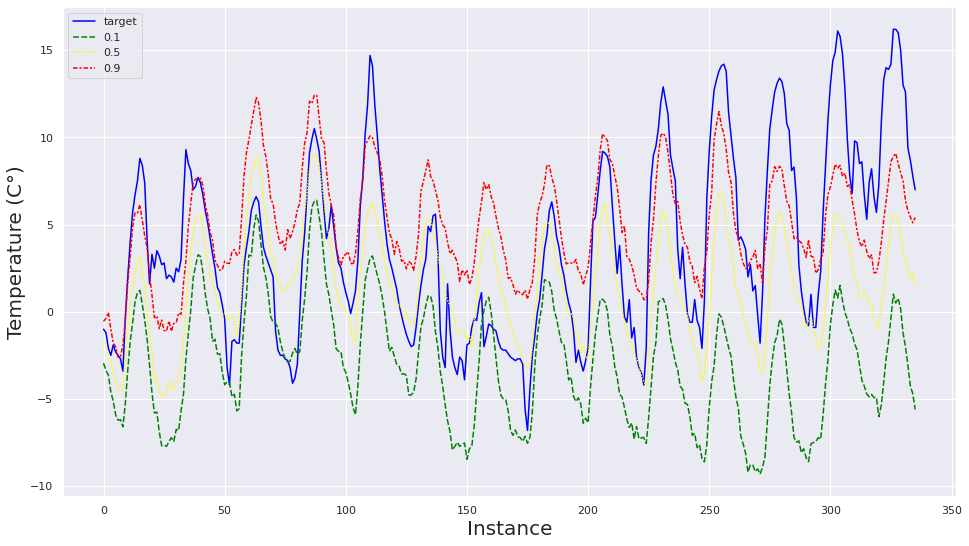

In [272]:
sns.set(rc={'figure.figsize': (16, 9)})
sns.set_palette("pastel")
figure = sns.lineplot(data = deepar_results[0], palette=['blue', 'green', 'yellow', 'red'])
figure.set_xlabel("Instance", fontsize = 20)
figure.set_ylabel("Temperature (C°)", fontsize = 20)
plt.show()

![DeepAR Results Graph](./images/deepar_results_graph.png)

As we can see, the 0.1 and 0.9 quantiles create an 80% confidence interval for our predictions, which our target generally stays within. However, as mentioned in the [DeepAR Best Practices](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html#deepar_best_practices), our confidence interval becomes less accurate towards the end due to our relatively high `prediction_length` value. To remediate this, lowering the frequency of data, such as changing `1min` to `5min`, or `H` to `D` (hourly to daily), is recommended.

# Amazon Forecast
In contrast to **DeepAR on SageMaker**, **Amazon Forecast** can be used without writing any code, and offers `6` algorithms:
 - **CNN-QR**
 - **DeepAR+**
 - **Prophet**
 - **NPTS**
 - **ARIMA**
 - **ETS**

If unsure of which algorithm suits your use case, a top-level comparison for which algorithm is the best option for your dataset can be found here: [Comparing Forecast Algorithms](https://docs.aws.amazon.com/forecast/latest/dg/aws-forecast-choosing-recipes.html#comparing-algos). 

In [288]:
region = sagemaker_session.boto_region_name

forecast_client = boto3.client('forecast', region_name = region)

## Dataset Group
Domains include 
- RETAIL
- CUSTOM
- INVENTORY_PLANNING
- EC2_CAPACITY
- WORK_FORCE
- WEB_TRAFFIC
- METRICS

In [290]:
forecast_project_name = "forecast_demo_{}_".format(version)

In [293]:
dataset_group_response = forecast_client.create_dataset_group(
    DatasetGroupName="{}dataset_group".format(forecast_project_name),
    Domain='CUSTOM',
)

In [294]:
print(dataset_group_response)

{'DatasetGroupArn': 'arn:aws:forecast:us-east-1:688520471316:dataset-group/forecast_demo_1_dataset_group', 'ResponseMetadata': {'RequestId': 'b69eae22-4ba1-403b-b916-073fefb703e1', 'HTTPStatusCode': 200, 'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1', 'date': 'Tue, 02 Aug 2022 03:06:19 GMT', 'x-amzn-requestid': 'b69eae22-4ba1-403b-b916-073fefb703e1', 'content-length': '105', 'connection': 'keep-alive'}, 'RetryAttempts': 0}}


## Target Dataset

In [303]:
forecast_target_time_series = pd.concat(dataset)
display(forecast_target_time_series)

,datetime,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,2013-03-01 00:00:00,8.0,8.0,6.0,28.0,400.0,52.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Wanliu
1,2013-03-01 01:00:00,9.0,9.0,6.0,28.0,400.0,50.0,-1.1,1023.2,-18.2,0.0,N,4.7,Wanliu
2,2013-03-01 02:00:00,3.0,6.0,NaN,19.0,400.0,55.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Wanliu
3,2013-03-01 03:00:00,11.0,30.0,8.0,14.0,NaN,NaN,-1.4,1024.5,-19.4,0.0,NW,3.1,Wanliu
4,2013-03-01 04:00:00,3.0,13.0,9.0,NaN,300.0,54.0,-2.0,1025.2,-19.5,0.0,N,2.0,Wanliu
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,2017-02-28 19:00:00,20.0,48.0,2.0,NaN,500.0,NaN,12.5,1013.5,-16.2,0.0,NW,2.4,Tiantan
35060,2017-02-28 20:00:00,11.0,34.0,3.0,36.0,500.0,NaN,11.6,1013.6,-15.1,0.0,WNW,0.9,Tiantan
35061,2017-02-28 21:00:00,18.0,32.0,4.0,48.0,500.0,48.0,10.8,1014.2,-13.3,0.0,NW,1.1,Tiantan
35062,2017-02-28 22:00:00,15.0,42.0,5.0,52.0,600.0,44.0,10.5,1014.4,-12.9,0.0,NNW,1.2,Tiantan


# TO DO
- FINISH SCHEMA
- TURN ALL NON TARGET COLUMNS TO FLOAT
- CREATE DATASET
- S3 UPLOAD
- IMPORT TO DATASET
- CREATE AUTO PREDICTOR
- CREATE DEEPAR PREDICTOR IN FORECAST
- GET PREDICTIONS
- (optional) GET INSIGHTS
- CONCLUSION

# Conclusion

In [ ]:
predictor.delete_model()
predictor.delete_endpoint()